# Exploration

https://github.com/yandexdataschool/Practical_RL/tree/master/week5_explore

In [1]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

from matplotlib import pyplot as plt
%matplotlib inline

# Part 1. Bernoulli Bandit
We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$
Where $\theta^* = \max_k\{\theta_k\}$

Real-world analogy:

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [3]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [4]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        
        pass

    def update(self, action, reward):
       
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))


## Epsilon-greedy agent
> for $t = 1,2,...$ do

>> for $k = 1,...,K$ do

>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> end for

>> $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

>end for

Implement the algorithm above in the cell below:

In [5]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.05):
        self._epsilon = epsilon

    def get_action(self):
        # YOUR CODE HERE
        prob = np.random.rand()
        
        if prob > self._epsilon:
            return np.argmax(self._successes / (self._successes + self._failures) )
        else:
            return np.random.choice(len(self._successes))
            
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)


## UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

> for $t = 1,2,...$ do

>> for $k = 1,...,K$ do

>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>>end for

>> $x_t \leftarrow argmax_{k}w$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> end for

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [6]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(self._successes / (self._successes + self._failures + 1e-5) 
                         + np.sqrt(2 * np.log(self._total_pulls + 1) / (self._successes + self._failures + 1e-5)))


## Thompson sampling
UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

> for $t = 1,2,...$ do

>> for $k = 1,...,K$ do

>>> Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> end for

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Apply $x_t$ and observe $r_t$

>>$(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> end for

More on Tompson Sampling: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [7]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(np.random.beta(self._successes + 1, 
                                        self._failures + 1))

In [8]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


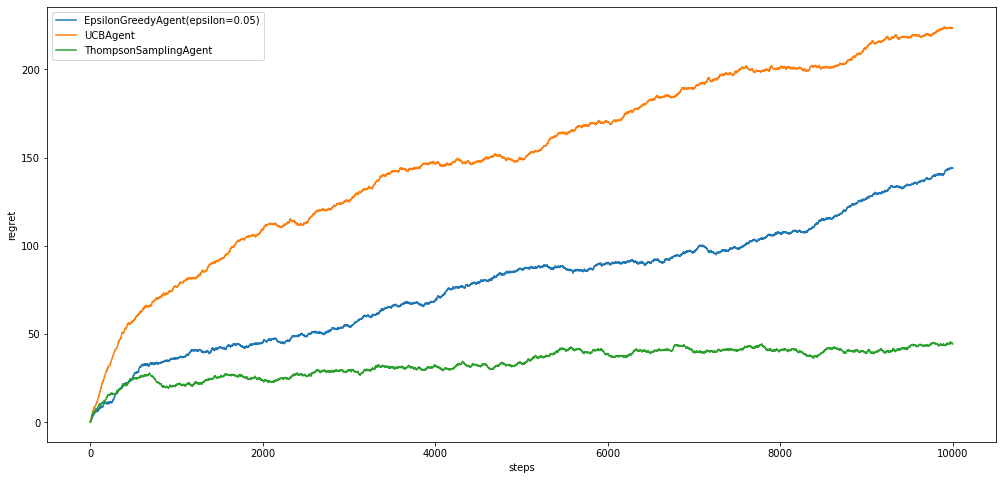

In [9]:
agents = [#RandomAgent(),
        EpsilonGreedyAgent(),
        UCBAgent(),
        ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

# Nonstationary Bernoulli bandit
What if success probabilities change over time? Here is an example of such bandit:

In [10]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

And a picture how it's reward probabilities change over time

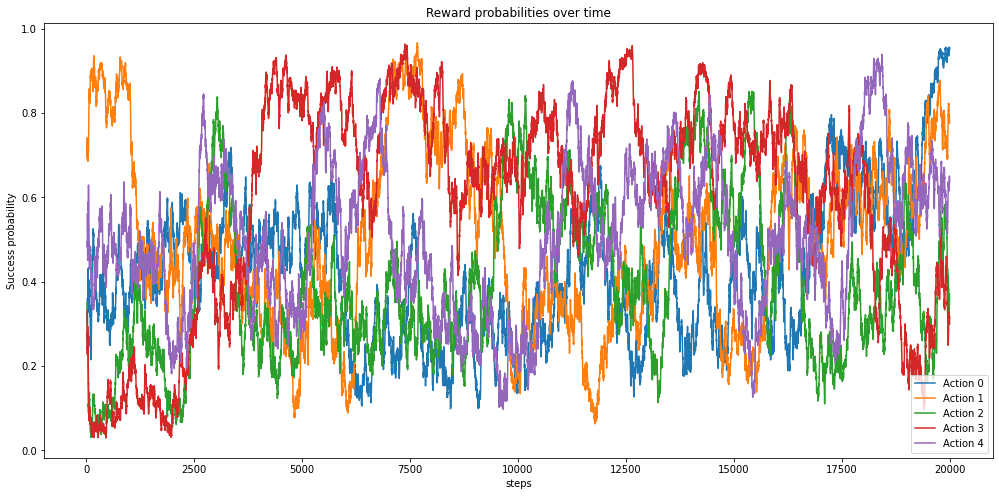

In [11]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


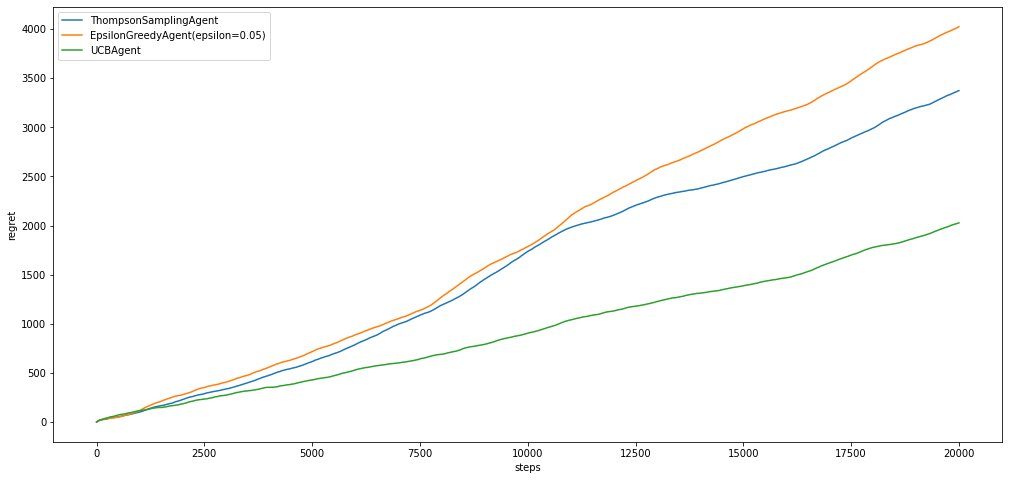

In [12]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
]

plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)